In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2021-09-22.zip to 2021-09-22.zip


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import re
import networkx
import numpy as np

###Unzip Contents of Folder and Merging DFs

In [ ]:
name_f = '2021-09-22'
folder_name = '/content/' + name_f #REPLACE FOLDER NAME

!unzip /content/2021-09-22.zip #REPLACE FOLDER NAME

Archive:  /content/2021-09-22.zip
   creating: 2021-09-22/
  inflating: 2021-09-22/bakuna-2021-09-22.csv  
  inflating: 2021-09-22/coronavirus-2021-09-22.csv  
  inflating: 2021-09-22/covid19-2021-09-22.csv  
  inflating: 2021-09-22/covid19nohashtag-2021-09-22.csv  
  inflating: 2021-09-22/covid19ph-2021-09-22.csv  
  inflating: 2021-09-22/covid19phEn-2021-09-22.csv  
  inflating: 2021-09-22/resbakuna-2021-09-22.csv  


In [ ]:
from os import walk

filenames = next(walk(folder_name), (None, None, []))[2]  # [] if no file

folder_df = []
for f in filenames:
  csv_file = folder_name + '/' + f
  df_one_file = pd.read_csv(csv_file, encoding="utf-8")
  folder_df.append(df_one_file)

df = pd.concat(folder_df, ignore_index=True).reset_index(drop=True)
#df = pd.read_csv('/content/test5-2021-09-13.csv', encoding="utf-8")

###Export CSV
filename_export = name_f + '_raw.csv'
df['verdict'] = 'true'
df.to_csv(filename_export,index=False)

df['RT'] = False
df['RTUser'] = 'NA'
df['source_user'] = 'NA'
df['target_user'] = 'NA'
df['mentions'] = 'NA'
df

,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,RT,RTUser,source_user,target_user,mentions
0,630857697,PIACaraga,2021-09-21 23:53:36+00:00,,1440464259993903109,tl,0,0,0,2,Twitter for Android,"RT @pcoogov: TINGNAN: Kahapon, Setyembre 20, i...",False,NA,NA,NA,NA
1,630857697,PIACaraga,2021-09-21 23:53:27+00:00,,1440464221540474894,tl,0,0,0,6,Twitter for Android,RT @pcoogov: TINGNAN: Nakatanggap ng additiona...,False,NA,NA,NA,NA
2,630857697,PIACaraga,2021-09-21 23:53:17+00:00,,1440464177160593409,tl,0,0,0,3,Twitter for Android,"RT @pcoogov: TINGNAN: Nitong Lunes, Setyembre ...",False,NA,NA,NA,NA
3,630857697,PIACaraga,2021-09-21 23:52:36+00:00,,1440464007802986499,tl,0,0,0,3,Twitter for Android,RT @pcoogov: TINGNAN: Ipinabatid ni Presidenti...,False,NA,NA,NA,NA
4,630857697,PIACaraga,2021-09-21 23:52:23+00:00,,1440463951901298693,tl,0,0,0,2,Twitter for Android,"RT @pcoogov: PANOORIN: Kahapon, Setyembre 20, ...",False,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,1384613267620777995,moonchild_kni21,2021-09-16 01:39:07+00:00,,1438316483776552966,tl,1,0,0,0,Twitter Web App,fvcking coronavirus,False,NA,NA,NA,NA
9133,1049111911952867328,furaaanzu,2021-09-16 01:39:03+00:00,,1438316467431227393,tl,1,0,1,0,Twitter for Android,"""oh sige, ikaw na! sayo na ang korona kasama a...",False,NA,NA,NA,NA
9134,1229709063044231168,GMARTVNews,2021-09-16 01:25:00+00:00,,1438312931968491522,tl,0,0,0,0,TweetDeck,"ALBAY — COVID-19 surge plan, inilatag na ng DO...",False,NA,NA,NA,NA
9135,1229709063044231168,GMARTVNews,2021-09-16 01:15:00+00:00,,1438310415499501572,tl,0,0,0,0,TweetDeck,"CALASIAO, PANGASINAN — Ilang pasyente sa Calas...",False,NA,NA,NA,NA


###Segregating People Who Retweeted, and the Usernames. Adding into source_user and target_user as well

In [ ]:
for i in df.index:
  i = int(i)
  row = df.iloc[i]
  username_df = row.tweet.split(" ")
  if username_df[0] == 'RT':
    username_rt = str(username_df[1])[1:-1]
    df.at[i,'RT'] = True
    df.at[i,'RTUser'] = username_rt
    df.at[i,'source_user'] = username_rt
    df.at[i,'target_user'] = row.username
    
df

,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,RT,RTUser,source_user,target_user,mentions
0,630857697,PIACaraga,2021-09-21 23:53:36+00:00,,1440464259993903109,tl,0,0,0,2,Twitter for Android,"RT @pcoogov: TINGNAN: Kahapon, Setyembre 20, i...",True,pcoogov,pcoogov,PIACaraga,NA
1,630857697,PIACaraga,2021-09-21 23:53:27+00:00,,1440464221540474894,tl,0,0,0,6,Twitter for Android,RT @pcoogov: TINGNAN: Nakatanggap ng additiona...,True,pcoogov,pcoogov,PIACaraga,NA
2,630857697,PIACaraga,2021-09-21 23:53:17+00:00,,1440464177160593409,tl,0,0,0,3,Twitter for Android,"RT @pcoogov: TINGNAN: Nitong Lunes, Setyembre ...",True,pcoogov,pcoogov,PIACaraga,NA
3,630857697,PIACaraga,2021-09-21 23:52:36+00:00,,1440464007802986499,tl,0,0,0,3,Twitter for Android,RT @pcoogov: TINGNAN: Ipinabatid ni Presidenti...,True,pcoogov,pcoogov,PIACaraga,NA
4,630857697,PIACaraga,2021-09-21 23:52:23+00:00,,1440463951901298693,tl,0,0,0,2,Twitter for Android,"RT @pcoogov: PANOORIN: Kahapon, Setyembre 20, ...",True,pcoogov,pcoogov,PIACaraga,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,1384613267620777995,moonchild_kni21,2021-09-16 01:39:07+00:00,,1438316483776552966,tl,1,0,0,0,Twitter Web App,fvcking coronavirus,False,NA,NA,NA,NA
9133,1049111911952867328,furaaanzu,2021-09-16 01:39:03+00:00,,1438316467431227393,tl,1,0,1,0,Twitter for Android,"""oh sige, ikaw na! sayo na ang korona kasama a...",False,NA,NA,NA,NA
9134,1229709063044231168,GMARTVNews,2021-09-16 01:25:00+00:00,,1438312931968491522,tl,0,0,0,0,TweetDeck,"ALBAY — COVID-19 surge plan, inilatag na ng DO...",False,NA,NA,NA,NA
9135,1229709063044231168,GMARTVNews,2021-09-16 01:15:00+00:00,,1438310415499501572,tl,0,0,0,0,TweetDeck,"CALASIAO, PANGASINAN — Ilang pasyente sa Calas...",False,NA,NA,NA,NA


In [ ]:
def remove_rt(tweet_row):
  tweet = ''
  split_str = tweet_row.split(" ")
  if split_str[0]=='RT':
    split_str.pop(0)
    split_str.pop(0)
    tweet = ' '.join([word for word in split_str])
    return tweet
  else:
    return tweet_row

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_rt(x))
df

,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,RT,RTUser,source_user,target_user,mentions
0,630857697,PIACaraga,2021-09-21 23:53:36+00:00,,1440464259993903109,tl,0,0,0,2,Twitter for Android,"TINGNAN: Kahapon, Setyembre 20, inilabas ni @n...",True,pcoogov,pcoogov,PIACaraga,NA
1,630857697,PIACaraga,2021-09-21 23:53:27+00:00,,1440464221540474894,tl,0,0,0,6,Twitter for Android,TINGNAN: Nakatanggap ng additional doses ng Pf...,True,pcoogov,pcoogov,PIACaraga,NA
2,630857697,PIACaraga,2021-09-21 23:53:17+00:00,,1440464177160593409,tl,0,0,0,3,Twitter for Android,"TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...",True,pcoogov,pcoogov,PIACaraga,NA
3,630857697,PIACaraga,2021-09-21 23:52:36+00:00,,1440464007802986499,tl,0,0,0,3,Twitter for Android,TINGNAN: Ipinabatid ni Presidential Spokespers...,True,pcoogov,pcoogov,PIACaraga,NA
4,630857697,PIACaraga,2021-09-21 23:52:23+00:00,,1440463951901298693,tl,0,0,0,2,Twitter for Android,"PANOORIN: Kahapon, Setyembre 20, nagbigay ng u...",True,pcoogov,pcoogov,PIACaraga,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,1384613267620777995,moonchild_kni21,2021-09-16 01:39:07+00:00,,1438316483776552966,tl,1,0,0,0,Twitter Web App,fvcking coronavirus,False,NA,NA,NA,NA
9133,1049111911952867328,furaaanzu,2021-09-16 01:39:03+00:00,,1438316467431227393,tl,1,0,1,0,Twitter for Android,"""oh sige, ikaw na! sayo na ang korona kasama a...",False,NA,NA,NA,NA
9134,1229709063044231168,GMARTVNews,2021-09-16 01:25:00+00:00,,1438312931968491522,tl,0,0,0,0,TweetDeck,"ALBAY — COVID-19 surge plan, inilatag na ng DO...",False,NA,NA,NA,NA
9135,1229709063044231168,GMARTVNews,2021-09-16 01:15:00+00:00,,1438310415499501572,tl,0,0,0,0,TweetDeck,"CALASIAO, PANGASINAN — Ilang pasyente sa Calas...",False,NA,NA,NA,NA


### Segregating Mentions and placing the remaining source_user and target_user

In [ ]:
for i in df.index:
  row = df.iloc[i]
  if row.RT == False:
    username_s = row.username
    mentions = [word[1:] for word in row.tweet.split(" ") if "@" in word]
    df.at[i,'source_user'] = username_s
    if mentions != []:
      df.at[i,'mentions'] = mentions
      df.at[i,'target_user'] = mentions
    

df

,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,RT,RTUser,source_user,target_user,mentions
0,630857697,PIACaraga,2021-09-21 23:53:36+00:00,,1440464259993903109,tl,0,0,0,2,Twitter for Android,"TINGNAN: Kahapon, Setyembre 20, inilabas ni @n...",True,pcoogov,pcoogov,PIACaraga,NA
1,630857697,PIACaraga,2021-09-21 23:53:27+00:00,,1440464221540474894,tl,0,0,0,6,Twitter for Android,TINGNAN: Nakatanggap ng additional doses ng Pf...,True,pcoogov,pcoogov,PIACaraga,NA
2,630857697,PIACaraga,2021-09-21 23:53:17+00:00,,1440464177160593409,tl,0,0,0,3,Twitter for Android,"TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...",True,pcoogov,pcoogov,PIACaraga,NA
3,630857697,PIACaraga,2021-09-21 23:52:36+00:00,,1440464007802986499,tl,0,0,0,3,Twitter for Android,TINGNAN: Ipinabatid ni Presidential Spokespers...,True,pcoogov,pcoogov,PIACaraga,NA
4,630857697,PIACaraga,2021-09-21 23:52:23+00:00,,1440463951901298693,tl,0,0,0,2,Twitter for Android,"PANOORIN: Kahapon, Setyembre 20, nagbigay ng u...",True,pcoogov,pcoogov,PIACaraga,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,1384613267620777995,moonchild_kni21,2021-09-16 01:39:07+00:00,,1438316483776552966,tl,1,0,0,0,Twitter Web App,fvcking coronavirus,False,NA,moonchild_kni21,NA,NA
9133,1049111911952867328,furaaanzu,2021-09-16 01:39:03+00:00,,1438316467431227393,tl,1,0,1,0,Twitter for Android,"""oh sige, ikaw na! sayo na ang korona kasama a...",False,NA,furaaanzu,NA,NA
9134,1229709063044231168,GMARTVNews,2021-09-16 01:25:00+00:00,,1438312931968491522,tl,0,0,0,0,TweetDeck,"ALBAY — COVID-19 surge plan, inilatag na ng DO...",False,NA,GMARTVNews,[@GMARegionalTV\n],[@GMARegionalTV\n]
9135,1229709063044231168,GMARTVNews,2021-09-16 01:15:00+00:00,,1438310415499501572,tl,0,0,0,0,TweetDeck,"CALASIAO, PANGASINAN — Ilang pasyente sa Calas...",False,NA,GMARTVNews,[@GMARegionalTV\n],[@GMARegionalTV\n]


###Dropping the columns not needed for the model

In [ ]:
df = df.drop(columns=['author id', 'created_at', 'RTUser', 'mentions', 'source' ])
df

,username,geo,id,lang,like_count,quote_count,reply_count,retweet_count,tweet,RT,source_user,target_user
0,PIACaraga,,1440464259993903109,tl,0,0,0,2,"TINGNAN: Kahapon, Setyembre 20, inilabas ni @n...",True,pcoogov,PIACaraga
1,PIACaraga,,1440464221540474894,tl,0,0,0,6,TINGNAN: Nakatanggap ng additional doses ng Pf...,True,pcoogov,PIACaraga
2,PIACaraga,,1440464177160593409,tl,0,0,0,3,"TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...",True,pcoogov,PIACaraga
3,PIACaraga,,1440464007802986499,tl,0,0,0,3,TINGNAN: Ipinabatid ni Presidential Spokespers...,True,pcoogov,PIACaraga
4,PIACaraga,,1440463951901298693,tl,0,0,0,2,"PANOORIN: Kahapon, Setyembre 20, nagbigay ng u...",True,pcoogov,PIACaraga
...,...,...,...,...,...,...,...,...,...,...,...,...
9132,moonchild_kni21,,1438316483776552966,tl,1,0,0,0,fvcking coronavirus,False,moonchild_kni21,NA
9133,furaaanzu,,1438316467431227393,tl,1,0,1,0,"""oh sige, ikaw na! sayo na ang korona kasama a...",False,furaaanzu,NA
9134,GMARTVNews,,1438312931968491522,tl,0,0,0,0,"ALBAY — COVID-19 surge plan, inilatag na ng DO...",False,GMARTVNews,[@GMARegionalTV\n]
9135,GMARTVNews,,1438310415499501572,tl,0,0,0,0,"CALASIAO, PANGASINAN — Ilang pasyente sa Calas...",False,GMARTVNews,[@GMARegionalTV\n]


### Duplicating rows with multiple target_users

In [ ]:
x = len(df.index)

for i in df.index:
  row = df.iloc[i]
  if type(row.target_user) is list:
    for j in range(1,len(row.target_user)):
      df = df.append(row,ignore_index=True)
      if "@" in row.target_user[j]:
        df.at[x,'target_user'] = df.at[x,'target_user'] = row.target_user[j][1:]
      else:
        df.at[x,'target_user'] = row.target_user[j]
      x += 1
    df.at[i,'target_user'] = row.target_user[0]


df

,username,geo,id,lang,like_count,quote_count,reply_count,retweet_count,tweet,RT,source_user,target_user
0,PIACaraga,,1440464259993903109,tl,0,0,0,2,"TINGNAN: Kahapon, Setyembre 20, inilabas ni @n...",True,pcoogov,PIACaraga
1,PIACaraga,,1440464221540474894,tl,0,0,0,6,TINGNAN: Nakatanggap ng additional doses ng Pf...,True,pcoogov,PIACaraga
2,PIACaraga,,1440464177160593409,tl,0,0,0,3,"TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...",True,pcoogov,PIACaraga
3,PIACaraga,,1440464007802986499,tl,0,0,0,3,TINGNAN: Ipinabatid ni Presidential Spokespers...,True,pcoogov,PIACaraga
4,PIACaraga,,1440463951901298693,tl,0,0,0,2,"PANOORIN: Kahapon, Setyembre 20, nagbigay ng u...",True,pcoogov,PIACaraga
...,...,...,...,...,...,...,...,...,...,...,...,...
10252,LokayaWishmitha,,1438376818273259521,tl,0,0,0,0,@proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...,False,LokayaWishmitha,Sri_Lanka_Army
10253,LokayaWishmitha,,1438376818273259521,tl,0,0,0,0,@proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...,False,LokayaWishmitha,GotabayaR
10254,LokayaWishmitha,,1438376818273259521,tl,0,0,0,0,@proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...,False,LokayaWishmitha,RajapaksaNamal
10255,LokayaWishmitha,,1438376818273259521,tl,0,0,0,0,@proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...,False,LokayaWishmitha,SriLankaPolice2


### Removal of Stopwords and Links


In [ ]:
import nltk
nltk.download('stopwords')
#English Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#English Stopwords
df.tweet = df['tweet'].apply(lambda x: ' '.join([word for word in x.split(" ") if word not in (stop)]))
df.tweet

0        TINGNAN: Kahapon, Setyembre 20, inilabas ni @n...
1        TINGNAN: Nakatanggap ng additional doses ng Pf...
2        TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...
3        TINGNAN: Ipinabatid ni Presidential Spokespers...
4        PANOORIN: Kahapon, Setyembre 20, nagbigay ng u...
                               ...                        
10252    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10253    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10254    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10255    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10256    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
Name: tweet, Length: 10257, dtype: object

In [ ]:
#Filipino Stopwords
fil_stop = ["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","at","atin","ating","ay","bababa","bago","bakit","bawat","bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang","hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring","maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang"]

In [ ]:
stop = fil_stop
df.tweet = df['tweet'].apply(lambda x: ' '.join([word for word in x.split(" ") if word not in (fil_stop)]))
df.tweet

0        TINGNAN: Kahapon, Setyembre 20, inilabas @ntfc...
1        TINGNAN: Nakatanggap additional doses Pfizer C...
2        TINGNAN: Nitong Lunes, Setyembre 20, kinuwesti...
3        TINGNAN: Ipinabatid Presidential Spokesperson ...
4        PANOORIN: Kahapon, Setyembre 20, nagbigay upda...
                               ...                        
10252    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10253    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10254    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10255    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
10256    @proud_Buddhist1 @RRekshan @Sri_Lanka_Army @Go...
Name: tweet, Length: 10257, dtype: object

In [ ]:
#Double check if we need links
df.tweet = df['tweet'].apply(lambda x: " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", x).split()))
df.tweet

0        TINGNAN Kahapon Setyembre 20 inilabas ntfcovid...
1        TINGNAN Nakatanggap additional doses Pfizer CO...
2        TINGNAN Nitong Lunes Setyembre 20 kinuwestiyon...
3        TINGNAN Ipinabatid Presidential Spokesperson S...
4        PANOORIN Kahapon Setyembre 20 nagbigay updates...
                               ...                        
10252    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10253    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10254    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10255    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10256    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
Name: tweet, Length: 10257, dtype: object

###Removal of Collection Words

In [ ]:
collection_words = ['covid19ph', 'covid-19', 'bakuna', 'resbakuna', 'coronavirus', '#covid19']

df.tweet = df['tweet'].apply(lambda x: ' '.join([word for word in x.split(" ") if word not in (collection_words)]))
df.tweet

0        TINGNAN Kahapon Setyembre 20 inilabas ntfcovid...
1        TINGNAN Nakatanggap additional doses Pfizer CO...
2        TINGNAN Nitong Lunes Setyembre 20 kinuwestiyon...
3        TINGNAN Ipinabatid Presidential Spokesperson S...
4        PANOORIN Kahapon Setyembre 20 nagbigay updates...
                               ...                        
10252    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10253    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10254    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10255    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
10256    proudBuddhist1 RRekshan SriLankaArmy GotabayaR...
Name: tweet, Length: 10257, dtype: object

###Lower case all words

In [ ]:
df.tweet = df['tweet'].apply(lambda x: x.lower())
df.tweet

0        tingnan kahapon setyembre 20 inilabas ntfcovid...
1        tingnan nakatanggap additional doses pfizer co...
2        tingnan nitong lunes setyembre 20 kinuwestiyon...
3        tingnan ipinabatid presidential spokesperson s...
4        panoorin kahapon setyembre 20 nagbigay updates...
                               ...                        
10252    proudbuddhist1 rrekshan srilankaarmy gotabayar...
10253    proudbuddhist1 rrekshan srilankaarmy gotabayar...
10254    proudbuddhist1 rrekshan srilankaarmy gotabayar...
10255    proudbuddhist1 rrekshan srilankaarmy gotabayar...
10256    proudbuddhist1 rrekshan srilankaarmy gotabayar...
Name: tweet, Length: 10257, dtype: object

### Download data frame to csv

In [ ]:
filename_export = name_f + '.csv'
df.to_csv(filename_export,index=False)
#files.download(filename_export)

###Getting Word Frequency

In [ ]:
df.tweet.str.split(expand=True).stack().value_counts()

covid19      4474
ba           1187
po           1032
nga           980
ito           843
             ... 
nawong          1
nagmamaru       1
nkabyumva       1
mainit          1
xde             1
Length: 15114, dtype: int64

In [ ]:
# List of all words across tweets
words_in_tweet = [tweet.lower().split() for tweet in df.tweet]
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(30)

[('covid19', 4474),
 ('ba', 1187),
 ('po', 1032),
 ('nga', 980),
 ('ito', 843),
 ('pandemya', 767),
 ('dating', 764),
 ('mataas', 746),
 ('mundo', 732),
 ('mananaliksik', 719),
 ('makakatapos', 718),
 ('pagasa', 718),
 ('makababalik', 718),
 ('bu', 714),
 ('cases', 672),
 ('lang', 658),
 ('ka', 628),
 ('mo', 605),
 ('sa', 604),
 ('bakuna', 593),
 ('covid19ph', 562),
 ('palayo', 556),
 ('na', 535),
 ('health', 494),
 ('yung', 473),
 ('kaso', 443),
 ('pag', 434),
 ('covid', 396),
 ('bansa', 381),
 ('naman', 378)]

###Visualization

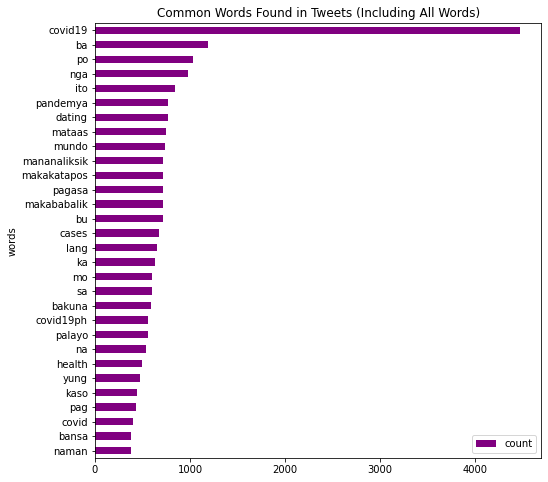

In [ ]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(30),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

### N-grams

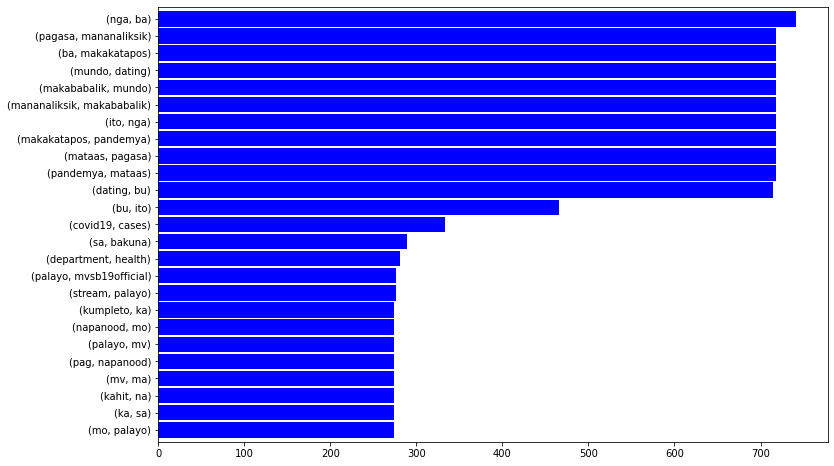

In [ ]:
#https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

bigram_sample = (pd.Series(nltk.ngrams(all_words_no_urls, 2)).value_counts())[:25]
bigram_sample.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

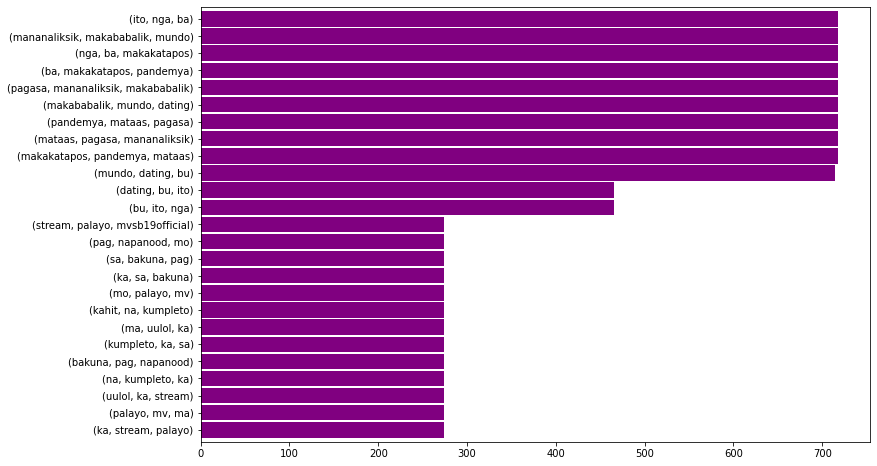

In [ ]:
bigram_sample = (pd.Series(nltk.ngrams(all_words_no_urls, 3)).value_counts())[:25]
bigram_sample.sort_values().plot.barh(color='purple', width=.9, figsize=(12, 8))